In [1]:
import tensorflow as tf
import pickle
import numpy as np
import time
import load_cifar

In [2]:
tf.reset_default_graph()

<h1>Define Hyper-perparmeter</h1>

In [3]:
num_classes = 10
num_features = 3072
num_output = 10
n_hidden_1 = 1000
n_hidden_2 = 500
n_hidden_3 = 250
n_hidden_4 = 100
n_hidden_5 = 50
n_hidden_6 = 20
lr = 0.001
batch_size = 32
epochs = 50
dropout_prob = 0.3

<h1>Define Placeholder</h1>

In [4]:
# Placeholders for the input data
X = tf.placeholder('float32',shape =(None,num_features),name="X")
Y = tf.placeholder('float32',shape = (None,num_classes),name="Y")
## for dropout layer
# keep_prob = tf.placeholder(tf.float32)
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_features, n_hidden_1],stddev=0.1),name='W1'),
    'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.1),name='W2'),
    'W3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.1), name='W3'),
    'W4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4],stddev=0.1), name='W4'),
    'W5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5],stddev=0.1), name='W5'),
    'W6': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_6],stddev=0.1), name='W6'),
    'Wout': tf.Variable(tf.random_normal([n_hidden_6, num_classes],stddev=0.1),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden_1]),name='b1'),
    'b2': tf.Variable(tf.zeros(shape=[n_hidden_2]),name='b2'),
    'b3': tf.Variable(tf.zeros(shape=[n_hidden_3]),name='b3'),
    'b4': tf.Variable(tf.zeros(shape=[n_hidden_4]),name='b4'),
    'b5': tf.Variable(tf.zeros(shape=[n_hidden_5]), name='b5'),
    'b6': tf.Variable(tf.zeros(shape=[n_hidden_6]), name='b6'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

<h1>Define Neural Network Architecture</h1>

In [5]:
def neural_net(x):
    layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
    layer_2_out = tf.nn.relu(tf.add(tf.matmul(layer_1_out,weights['W2']),biases['b2']))
    layer_3_out = tf.nn.relu(tf.add(tf.matmul(layer_2_out, weights['W3']), biases['b3']))
    layer_4_out = tf.nn.relu(tf.add(tf.matmul(layer_3_out, weights['W4']), biases['b4']))
    layer_5_out = tf.nn.relu(tf.add(tf.matmul(layer_4_out, weights['W5']), biases['b5']))
    layer_6_out = tf.nn.relu(tf.add(tf.matmul(layer_5_out, weights['W6']), biases['b6']))
    out = tf.add(tf.matmul(layer_6_out,weights['Wout']),biases['bout'])
    return out

#predicted labels
logits = neural_net(X)
Y_hat = tf.nn.softmax(logits)

<h1>Define cost andoptimization</h1>

In [6]:
## Defining the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y))
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(Y_hat,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

<h1>Training and testing</h1>
<h2>1.Print out validation accuracy after each training poch</h2>
<h2>2.Print out training time you spend on each epoch</h2>
<h2>3.Print out testing accuracy in the end</h2>

In [7]:
val_features, val_labels = pickle.load(open('val_data.pickle','rb'))
training_features,training_labels = pickle.load(open('train_data.pickle','rb'))
test_features, test_labels = pickle.load(open('test_data.pickle','rb'))
val_labels = np.squeeze(val_labels.todense())
training_labels = np.squeeze(training_labels.todense())
test_labels = np.squeeze(test_labels.todense())

In [8]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    data_shuffle = np.asarray(data_shuffle)
    labels_shuffle = np.asarray(labels_shuffle)
    labels_shuffle = np.squeeze(labels_shuffle)
    
    return data_shuffle, labels_shuffle

In [9]:
init = tf.global_variables_initializer()

total_batch = int(40000 / batch_size)
num_steps = (epochs + 1) * total_batch

acc_val_list = []

with tf.Session() as sess:
    sess.run(init)
    time_start = time.time()
    for i in range(num_steps):
        # fetch batch
        batch_x, batch_y = next_batch(batch_size, training_features, training_labels)
        # run optimization
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if (i > 1) and (i % total_batch == 0):
            time_end = time.time()
            l, acc = sess.run([loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
            acc_val = sess.run(accuracy, feed_dict={X: val_features, Y: val_labels})
            acc_val_list.append(acc_val)
            print("epoch " + str(int(i/total_batch)) + ", loss: {:.3f}".format(l) + \
                  ", acc: {:.3f}".format(acc) + ", acc_val:{:.3f}".format(acc_val) + \
                  ", time: {:.3f}\t".format(time_end-time_start))
            time_start = time.time()

    acc_test = sess.run(accuracy, feed_dict={X: test_features, Y: test_labels})
    print("acc_test: {:.3f}".format(acc_test))

epoch 1, loss: 1.863, acc: 0.250, acc_val:0.314, time: 3.981	
epoch 2, loss: 1.687, acc: 0.469, acc_val:0.398, time: 3.808	
epoch 3, loss: 1.625, acc: 0.375, acc_val:0.404, time: 4.009	
epoch 4, loss: 1.949, acc: 0.281, acc_val:0.401, time: 3.831	
epoch 5, loss: 1.590, acc: 0.438, acc_val:0.436, time: 4.039	
epoch 6, loss: 1.307, acc: 0.562, acc_val:0.446, time: 4.027	
epoch 7, loss: 1.288, acc: 0.500, acc_val:0.463, time: 3.981	
epoch 8, loss: 1.306, acc: 0.594, acc_val:0.475, time: 3.882	
epoch 9, loss: 1.197, acc: 0.562, acc_val:0.477, time: 3.699	
epoch 10, loss: 1.451, acc: 0.531, acc_val:0.476, time: 3.904	
epoch 11, loss: 1.321, acc: 0.594, acc_val:0.490, time: 3.976	
epoch 12, loss: 1.299, acc: 0.531, acc_val:0.476, time: 3.845	
epoch 13, loss: 1.211, acc: 0.531, acc_val:0.482, time: 3.937	
epoch 14, loss: 1.601, acc: 0.406, acc_val:0.479, time: 4.026	
epoch 15, loss: 0.957, acc: 0.688, acc_val:0.497, time: 3.833	
epoch 16, loss: 1.075, acc: 0.625, acc_val:0.486, time: 3.862	
e

Text(0, 0.5, 'Validation Accuracy (%)')

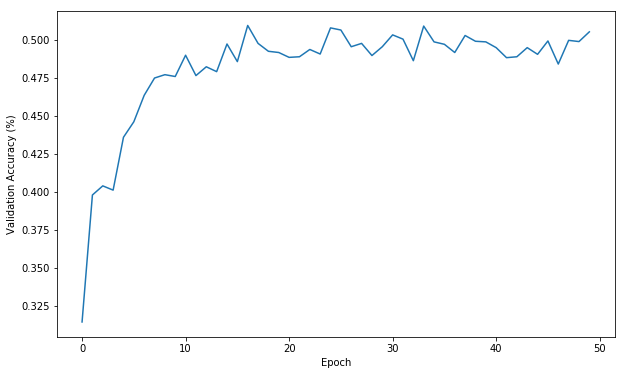

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(acc_val_list)), acc_val_list)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")

We can see that the validation accuracy cannot improve after about 10 epoches and remains at 50%. This is due to the limitation of the full connected neural networks.